In [1]:
!nvidia-smi

Mon Oct  2 00:10:10 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0              11W / 121W |   4439MiB /  6141MiB |     21%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchsummary import summary

In [16]:
from model import Net
from trainer import Trainer
from tester import Tester
from dataloader import Cifar10DataLoader
from utlis import visualize_data,show_misclassified_images
from viz import plot_confusion_matrix,plot_class_distribution,plot_curves

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [6]:
train_transforms =  transforms.Compose([
        transforms.RandomCrop(32),
        transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomRotation((-10., 10.), fill=1),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616)),
        # transforms.autoaugment.AutoAugmentPolicy('cifar10')
    ])

test_transforms  = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2470, 0.2435, 0.2616),
        )
    ])


In [7]:
cifar10 = Cifar10DataLoader(is_cuda_available=use_cuda)

train_loader = cifar10.get_loader(data_dir='../../data/',transforms=train_transforms, train=True)
test_loader = cifar10.get_loader(data_dir='../../data/',transforms=train_transforms, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# visualize_data(test_loader,16,"test data",classes=cifar10.classes)

In [9]:
# plot_class_distribution(test_loader,classes=cifar10.classes)

In [10]:
# model = Net(norm_method='gn',channels=[3,16,20,28,40,10],grp=4,dp_rate=0.1).to(device=device)
model = Net(norm_method='gn',channels=[3,8 ,16,24,32,10],grp=8,dp_rate=0.1).to(device)
summary(model=model,input_size=(3,32,32),batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
         GroupNorm-2            [-1, 8, 32, 32]              16
              ReLU-3            [-1, 8, 32, 32]               0
         Dropout2d-4            [-1, 8, 32, 32]               0
         ConvLayer-5            [-1, 8, 32, 32]               0
            Conv2d-6            [-1, 8, 32, 32]             576
         GroupNorm-7            [-1, 8, 32, 32]              16
              ReLU-8            [-1, 8, 32, 32]               0
         Dropout2d-9            [-1, 8, 32, 32]               0
        ConvLayer-10            [-1, 8, 32, 32]               0
           Conv2d-11            [-1, 8, 32, 32]              64
        MaxPool2d-12            [-1, 8, 16, 16]               0
       TransBlock-13            [-1, 8, 16, 16]               0
           Conv2d-14           [-1, 16,

In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()


trainer = Trainer(model, train_loader, optimizer, criterion, device)
tester = Tester(model, test_loader, criterion, device)

for epoch in range(1, 21):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.2 | Loss = 1.94 | Batch = 390 | Accuracy = 18.30: 100%|█| 391/391 [00:26<00:00, 15.04it/s


Test set: Average loss: 0.0149, Accuracy: 3257/10000 (32.57%)


EPOCH = 2 | LR = 0.2 | Loss = 1.74 | Batch = 390 | Accuracy = 32.97: 100%|█| 391/391 [00:24<00:00, 15.93it/s


Test set: Average loss: 0.0126, Accuracy: 4202/10000 (42.02%)


EPOCH = 3 | LR = 0.2 | Loss = 1.61 | Batch = 390 | Accuracy = 39.88: 100%|█| 391/391 [00:24<00:00, 16.03it/s


Test set: Average loss: 0.0118, Accuracy: 4536/10000 (45.36%)


EPOCH = 4 | LR = 0.2 | Loss = 1.47 | Batch = 390 | Accuracy = 43.53: 100%|█| 391/391 [00:24<00:00, 15.87it/s


Test set: Average loss: 0.0110, Accuracy: 5000/10000 (50.00%)


EPOCH = 5 | LR = 0.2 | Loss = 1.41 | Batch = 390 | Accuracy = 46.15: 100%|█| 391/391 [00:24<00:00, 15.78it/s


Test set: Average loss: 0.0107, Accuracy: 5138/10000 (51.38%)


EPOCH = 6 | LR = 0.2 | Loss = 1.38 | Batch = 390 | Accuracy = 48.33: 100%|█| 391/391 [00:24<00:00, 15.78it/s


Test set: Average loss: 0.0101, Accuracy: 5370/10000 (53.70%)


EPOCH = 7 | LR = 0.2 | Loss = 1.31 | Batch = 390 | Accuracy = 50.65: 100%|█| 391/391 [00:24<00:00, 15.97it/s


Test set: Average loss: 0.0095, Accuracy: 5638/10000 (56.38%)


EPOCH = 8 | LR = 0.2 | Loss = 1.14 | Batch = 390 | Accuracy = 52.38: 100%|█| 391/391 [00:24<00:00, 16.06it/s


Test set: Average loss: 0.0096, Accuracy: 5574/10000 (55.74%)


EPOCH = 9 | LR = 0.2 | Loss = 1.24 | Batch = 390 | Accuracy = 53.04: 100%|█| 391/391 [00:24<00:00, 15.79it/s


Test set: Average loss: 0.0092, Accuracy: 5879/10000 (58.79%)


EPOCH = 10 | LR = 0.2 | Loss = 1.16 | Batch = 390 | Accuracy = 54.26: 100%|█| 391/391 [00:25<00:00, 15.58it/


Test set: Average loss: 0.0088, Accuracy: 6050/10000 (60.50%)


EPOCH = 11 | LR = 0.2 | Loss = 1.22 | Batch = 390 | Accuracy = 54.68: 100%|█| 391/391 [00:24<00:00, 15.96it/


Test set: Average loss: 0.0090, Accuracy: 5892/10000 (58.92%)


EPOCH = 12 | LR = 0.2 | Loss = 1.29 | Batch = 390 | Accuracy = 55.72: 100%|█| 391/391 [00:24<00:00, 15.92it/


Test set: Average loss: 0.0092, Accuracy: 5860/10000 (58.60%)


EPOCH = 13 | LR = 0.2 | Loss = 1.11 | Batch = 390 | Accuracy = 56.45: 100%|█| 391/391 [00:24<00:00, 15.78it/


Test set: Average loss: 0.0085, Accuracy: 6197/10000 (61.97%)


EPOCH = 14 | LR = 0.2 | Loss = 1.62 | Batch = 390 | Accuracy = 57.09: 100%|█| 391/391 [00:25<00:00, 15.25it/


Test set: Average loss: 0.0085, Accuracy: 6185/10000 (61.85%)


EPOCH = 15 | LR = 0.2 | Loss = 1.14 | Batch = 390 | Accuracy = 57.59: 100%|█| 391/391 [00:24<00:00, 15.64it/


Test set: Average loss: 0.0083, Accuracy: 6301/10000 (63.01%)


EPOCH = 16 | LR = 0.2 | Loss = 1.08 | Batch = 390 | Accuracy = 57.97: 100%|█| 391/391 [00:24<00:00, 15.71it/


Test set: Average loss: 0.0082, Accuracy: 6360/10000 (63.60%)


EPOCH = 17 | LR = 0.2 | Loss = 1.17 | Batch = 390 | Accuracy = 58.41: 100%|█| 391/391 [00:24<00:00, 16.14it/


Test set: Average loss: 0.0081, Accuracy: 6351/10000 (63.51%)


EPOCH = 18 | LR = 0.2 | Loss = 1.26 | Batch = 390 | Accuracy = 58.76: 100%|█| 391/391 [00:24<00:00, 16.06it/


Test set: Average loss: 0.0080, Accuracy: 6422/10000 (64.22%)


EPOCH = 19 | LR = 0.2 | Loss = 1.10 | Batch = 390 | Accuracy = 59.37: 100%|█| 391/391 [00:24<00:00, 15.86it/


Test set: Average loss: 0.0082, Accuracy: 6235/10000 (62.35%)


EPOCH = 20 | LR = 0.2 | Loss = 1.18 | Batch = 390 | Accuracy = 59.42: 100%|█| 391/391 [00:24<00:00, 15.81it/


Test set: Average loss: 0.0079, Accuracy: 6461/10000 (64.61%)


In [12]:
misclassified_images, predictions, labels = tester.get_misclassified_images()

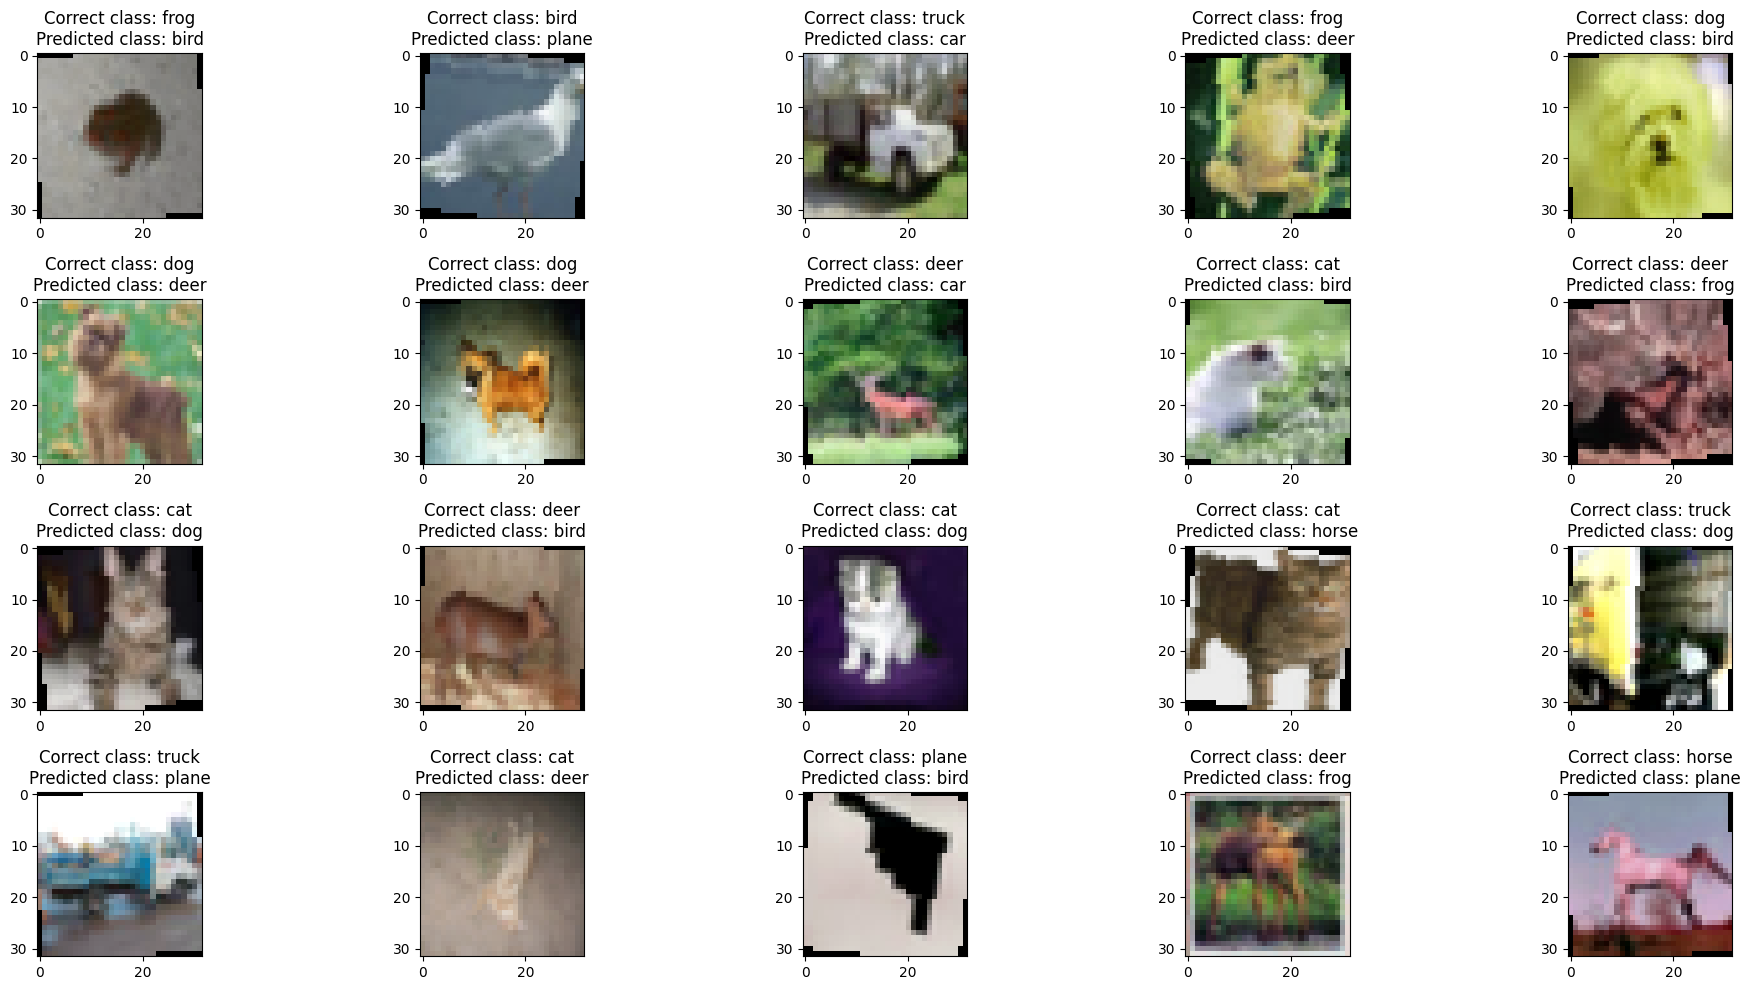

In [13]:
show_misclassified_images(
    misclassified_images[:20],
    predictions[:20],
    labels[:20],
    cifar10.classes,
)

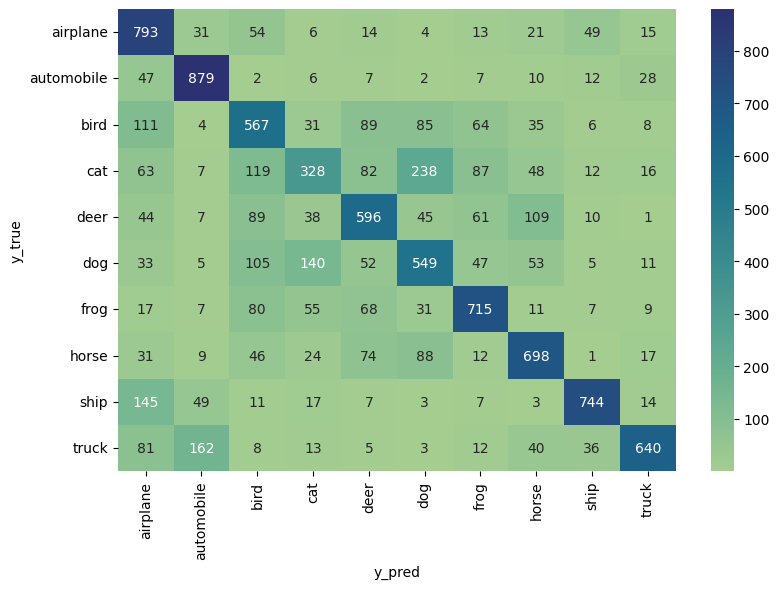

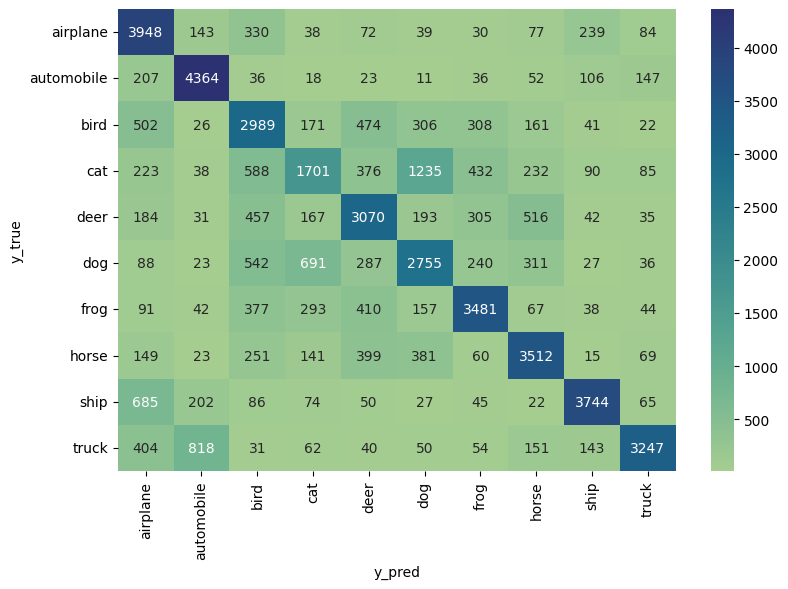

In [14]:

plot_confusion_matrix(model,test_loader,'cuda',test_loader.dataset.classes)
plot_confusion_matrix(model,train_loader,'cuda',train_loader.dataset.classes)

In [15]:
torch.save(model.state_dict(),'./best_models/model_gn8.pth')

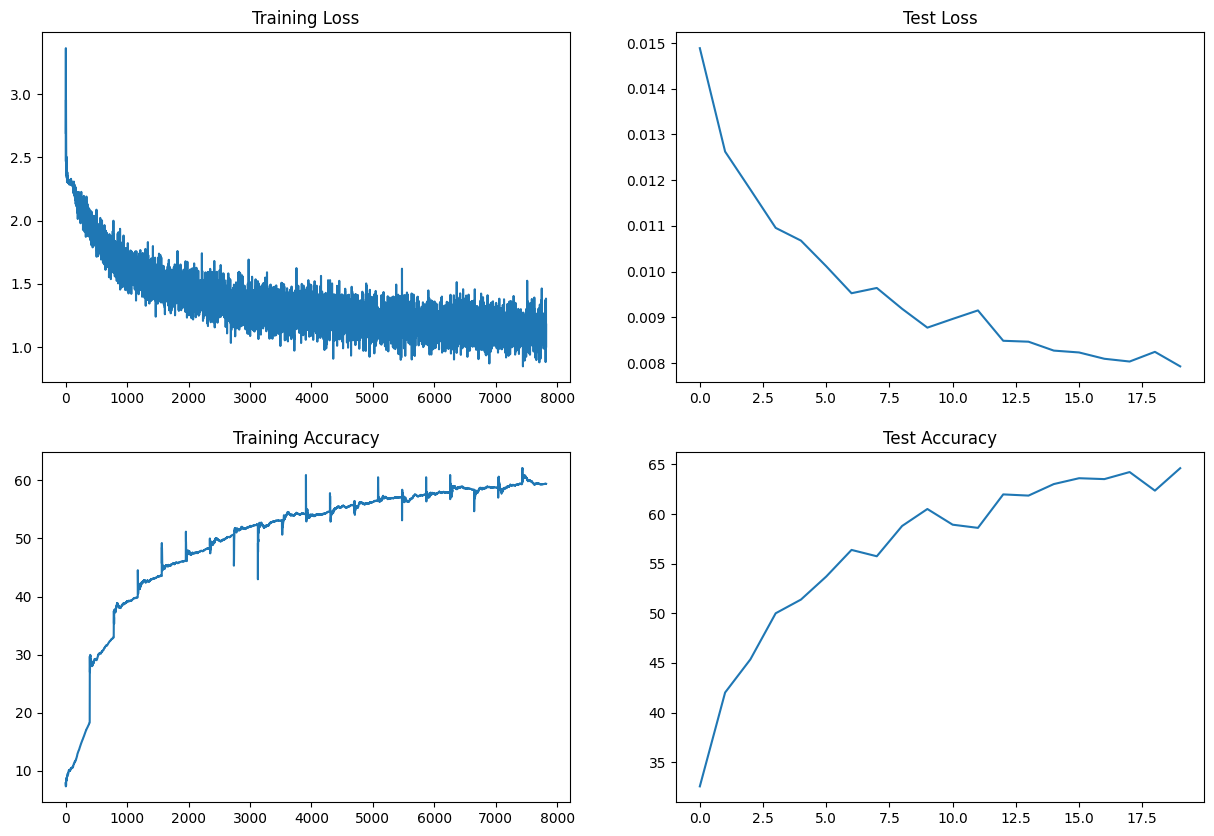

In [17]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)


In [18]:
class_name ='GN8'
import pandas as pd
pd.DataFrame([trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies]).T.rename(
        columns={
            0:f'{class_name}_train_loss',
            1:f'{class_name}_train_acc',
            2:f'{class_name}_test_loss',
            3:f'{class_name}_test_acc',
        }).to_csv(f'./traces/{class_name}.csv',index=False)